In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from import_utils import *

gan_file_path = '../models/DCGAN.py'

Discriminator, Generator = import_names(gan_file_path, 'DCGAN', 
                                        ['Discriminator', 'Generator'])

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision.utils as vutils

SEED = 0xDEADF00D
IMAGE_SIZE = 64
TEST_SIZE = 0.2

BATCH_SIZE = 16
NUM_EPOCHS = 10000
LR = 0.0002

EMBEDDING_SIZE = 100

# torch.backends.cudnn.deterministic = True
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

data_path = '../../data/faces'
dataset = ImageFolder(data_path,
                      transform=transforms.Compose([
                          transforms.Resize(IMAGE_SIZE),
                          transforms.CenterCrop(IMAGE_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ]))
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

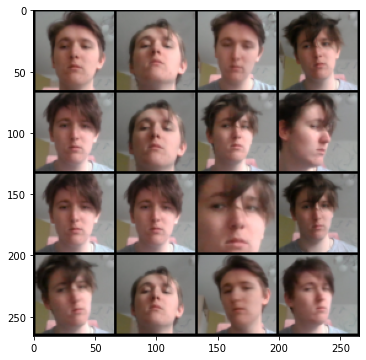

In [3]:
batch = [elem for elem in next(iter(data_loader))[0]]

plt.figure(figsize=(6,6))
plt.imshow(np.transpose(vutils.make_grid(batch, nrow=int(np.sqrt(BATCH_SIZE)), normalize=True), [1,2,0]));

In [4]:
from torch.optim import Adam

USE_CUDA = torch.cuda.is_available()
DTYPE = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor

gen = Generator().cuda() if USE_CUDA else Generator()
discr = Discriminator().cuda() if USE_CUDA else Discriminator()

opt_g = Adam(gen.parameters(), lr=LR)
opt_d = Adam(discr.parameters(), lr=LR)

In [5]:
def calc_gen_loss(discr_output):
    return -torch.mean(torch.log(discr_output))

def calc_discr_loss(discr_output_real, discr_output_fake):
    return -torch.mean(torch.log(discr_output_real)) - torch.mean(torch.log(1 - discr_output_fake))

def sample_noise(batch_size=BATCH_SIZE):
    return torch.rand(batch_size, EMBEDDING_SIZE, 1, 1)

def plot_generated_grid(batch_size=BATCH_SIZE):
    batch = gen(sample_noise(batch_size).type(DTYPE))
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(vutils.make_grid(batch, nrow=int(np.sqrt(BATCH_SIZE)), 
                                             normalize=True).clone().detach().cpu(), [1,2,0]))
    plt.show()
    
def get_grad_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** (1. / 2)
    
criterion = nn.BCELoss()

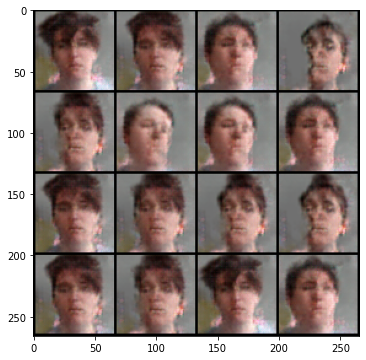

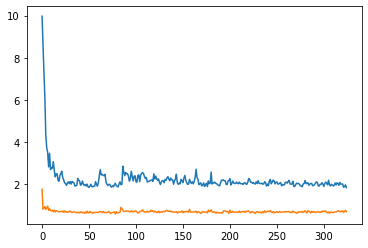

  3%|▎         | 325/10000 [13:19<6:37:35,  2.47s/it]

In [ ]:
from time import time
from tqdm import tqdm
from IPython import display

gen_loss, discr_loss = [], []

start_time = time()
gen_grad, discr_grad = 0, 0
for epoch in tqdm(range(NUM_EPOCHS)):
    tmp_gen_loss, tmp_discr_loss = [], []
    gen_grad_norm, discr_grad_norm = [], []
    
#     print(f'Prev epoch average generator grad norm: {gen_grad}')
#     print(f'Prev epoch average discriminator grad norm: {discr_grad}')
    
    for real_batch, _ in data_loader:
        discr.zero_grad()
        real_batch = real_batch.type(DTYPE)
        fake_batch = sample_noise(batch_size=real_batch.shape[0]).type(DTYPE)
        
        out_real = discr(real_batch).squeeze()
        out_fake = discr(gen(fake_batch)).squeeze()
        
        real_labels = .7 + torch.rand(real_batch.shape[0]).type(DTYPE) * .5
        fake_labels = torch.rand(real_batch.shape[0]).type(DTYPE) * .3
#         real_labels = torch.full((real_batch.shape[0],), 1.).type(DTYPE)
#         fake_labels = torch.full((real_batch.shape[0],), 0.).type(DTYPE)
        
        loss_d = criterion(out_real, real_labels)
        loss_d += criterion(out_fake, fake_labels)
        loss_d.backward()
#         discr_grad_norm.append(get_grad_norm(discr))
        opt_d.step()
        
        gen.zero_grad()
        out_discr = discr(gen(fake_batch)).squeeze()
        
        loss_g = criterion(out_discr, real_labels)
        loss_g.backward()
#         gen_grad_norm.append(get_grad_norm(gen))
        opt_g.step()
        
        tmp_gen_loss.append(loss_g.item())
        tmp_discr_loss.append(loss_d.item())
    
    gen_loss.append(np.mean(tmp_gen_loss))
    discr_loss.append(np.mean(tmp_discr_loss))
#     gen_grad, discr_grad = np.mean(gen_grad_norm), np.mean(discr_grad_norm)
    
    display.clear_output(wait=True)
    plot_generated_grid()
    plt.plot(gen_loss)
    plt.plot(discr_loss)
    plt.show()

print(f'Training took {time() - start_time} seconds')